# Line Background Estimation Using Adjacent Energy Bins

H.Yoneda, S. Mittal

This is a tutorial notebook on background estimation for gamma-ray lines.
The basic idea is as follows:
- Extracting the event distribution in the Compton data space from adjacent energy bins of the energy of interest.
- Making a binned histogram using the extracted events.
- Estimate the total number of expected background counts in the line energy bin by fitting the adjacent energy bin data, and modify the normalization of the binned histogram accordingly.

Here, we make a background model for Al-26. These processes will be performed in the `LineBackgroundEstimation` class, and you can see how it works as follows.

This class is very preliminary, and there are several areas for improvement. Future ideas include:
- We may add more options in the minuit fitting, e.g., limiting the parameter region, fixing some parameters.
- We may apply smoothing to the background histogram, which may help to mitigate Poisson fluctuation in the model.

In [1]:
import logging
import sys
logger = logging.getLogger('cosipy')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
from histpy import Histogram, Axis, Axes
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import integrate
from iminuit import Minuit
from cosipy import BinnedData, LineBackgroundEstimation

from cosipy.util import fetch_wasabi_file
from pathlib import Path

18:27:44 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=254431;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=124123;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=106782;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=607758;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=617049;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=840580;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=819292;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=982248;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=562163;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=485561;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=746887;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=108400;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=902103;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=41271;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

18:27:44 WARNING   ROOT minimizer not available                                                ]8;id=567190;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=432278;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=82169;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=738720;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=224765;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=43904;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=548305;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=939764;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=872410;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=786628;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=457529;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=151554;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=232254;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=761610;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=370488;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=120947;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=784848;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=218861;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=460223;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=505911;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## 0. Create dataset for the line background estimation

We need an event histogram binned finely along the energy axis.

In [4]:
# Change to your path
data_path = Path("")

Al_file = "26Al_NE2001_3months_unbinned_data_filtered_with_SAAcut.fits.gz"
bkg_file = "PrimaryProtons_3months_unbinned_data_filtered_with_SAAcut.fits.gz"

In [5]:
# Download files if needed
fetch_wasabi_file("COSI-SMEX/DC3/Data/Sources/"+Al_file, checksum = 'add408aae70caf59789c82b31020564a')
fetch_wasabi_file("COSI-SMEX/DC3/Data/Backgrounds/Ge/"+bkg_file, checksum = '3264e6bf520f4c20e06aaaed5d57abf0')

A file named 26Al_NE2001_3months_unbinned_data_filtered_with_SAAcut.fits.gz already exists with the specified checksum (add408aae70caf59789c82b31020564a). Skipping.
A file named PrimaryProtons_3months_unbinned_data_filtered_with_SAAcut.fits.gz already exists with the specified checksum (3264e6bf520f4c20e06aaaed5d57abf0). Skipping.


In [6]:
path_to_Al  = data_path/Al_file
path_to_bkg = data_path/bkg_file

In [7]:
#yaml files containing binning information
spectrum_bkg = BinnedData("inputs_bkg_estimation.yaml")
spectrum_Al = BinnedData("inputs_bkg_estimation.yaml")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


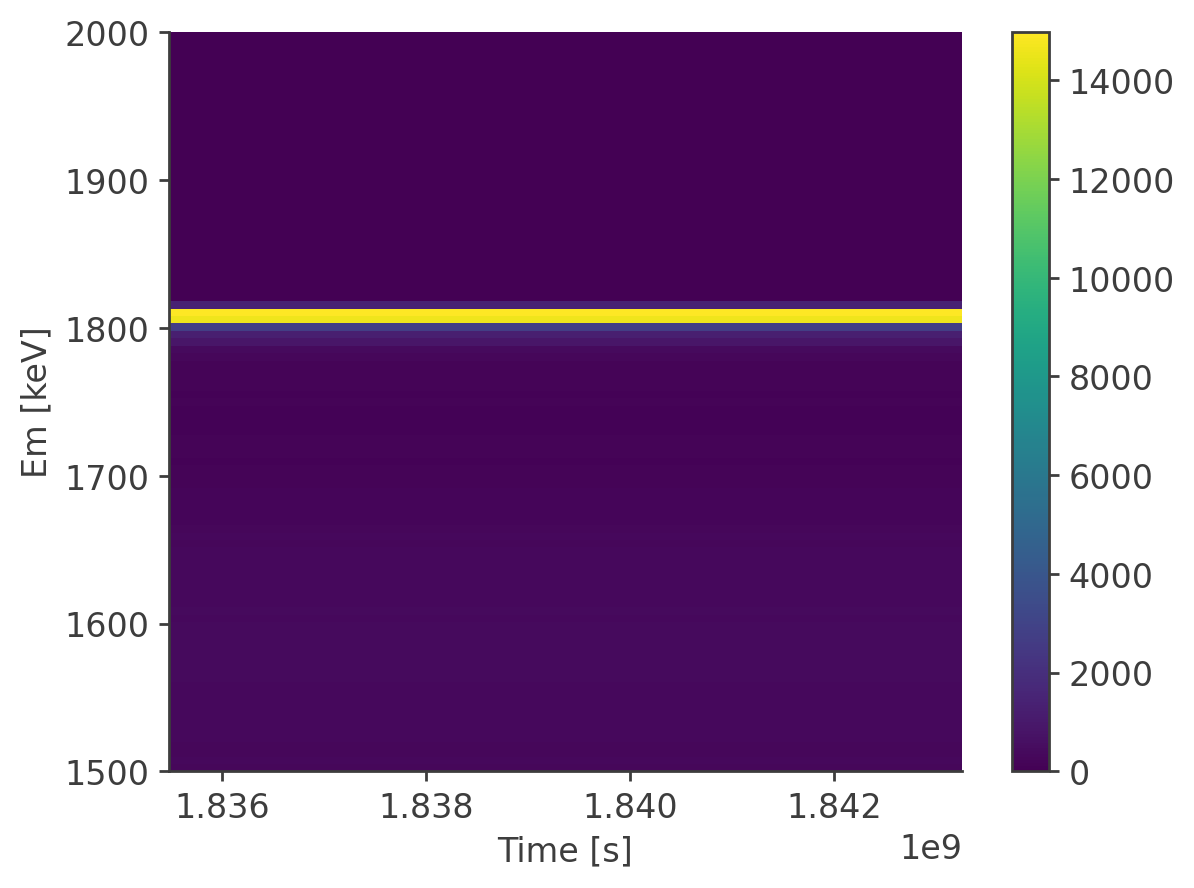

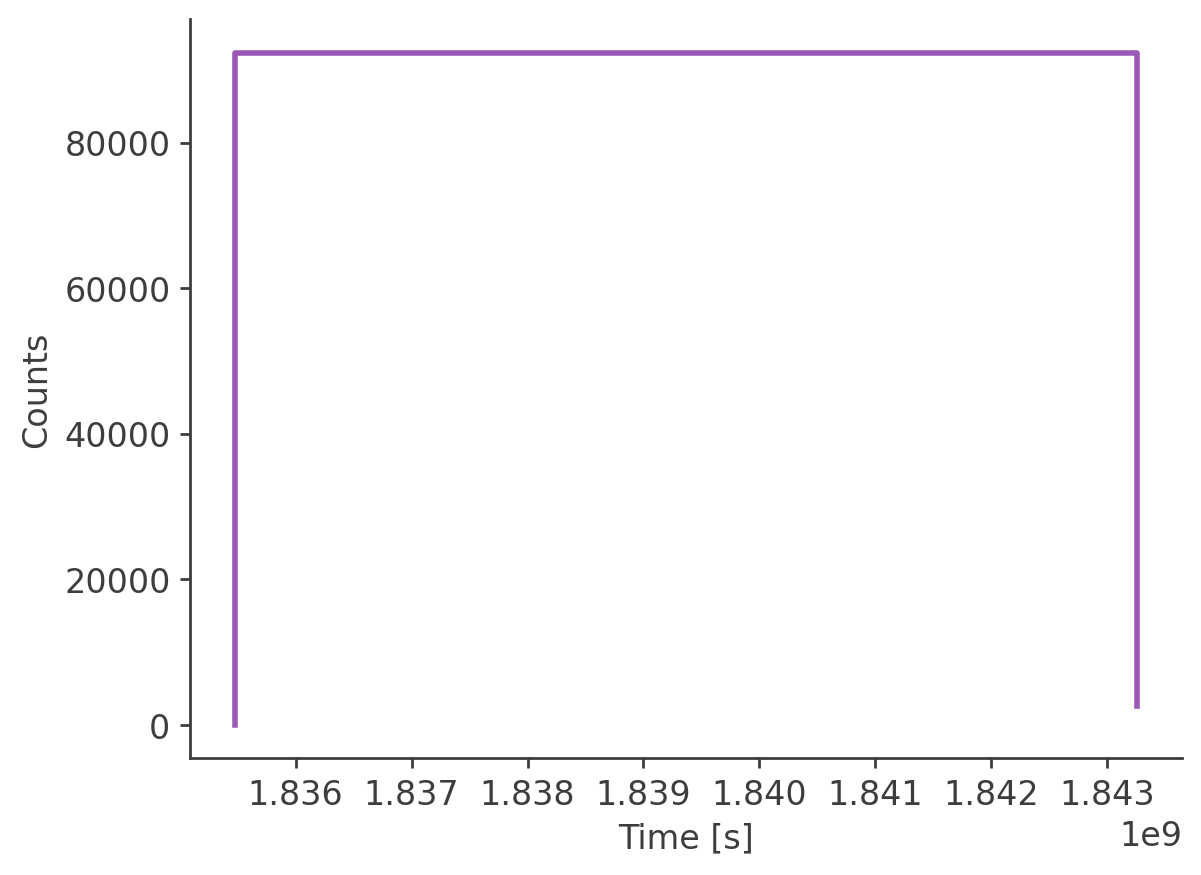

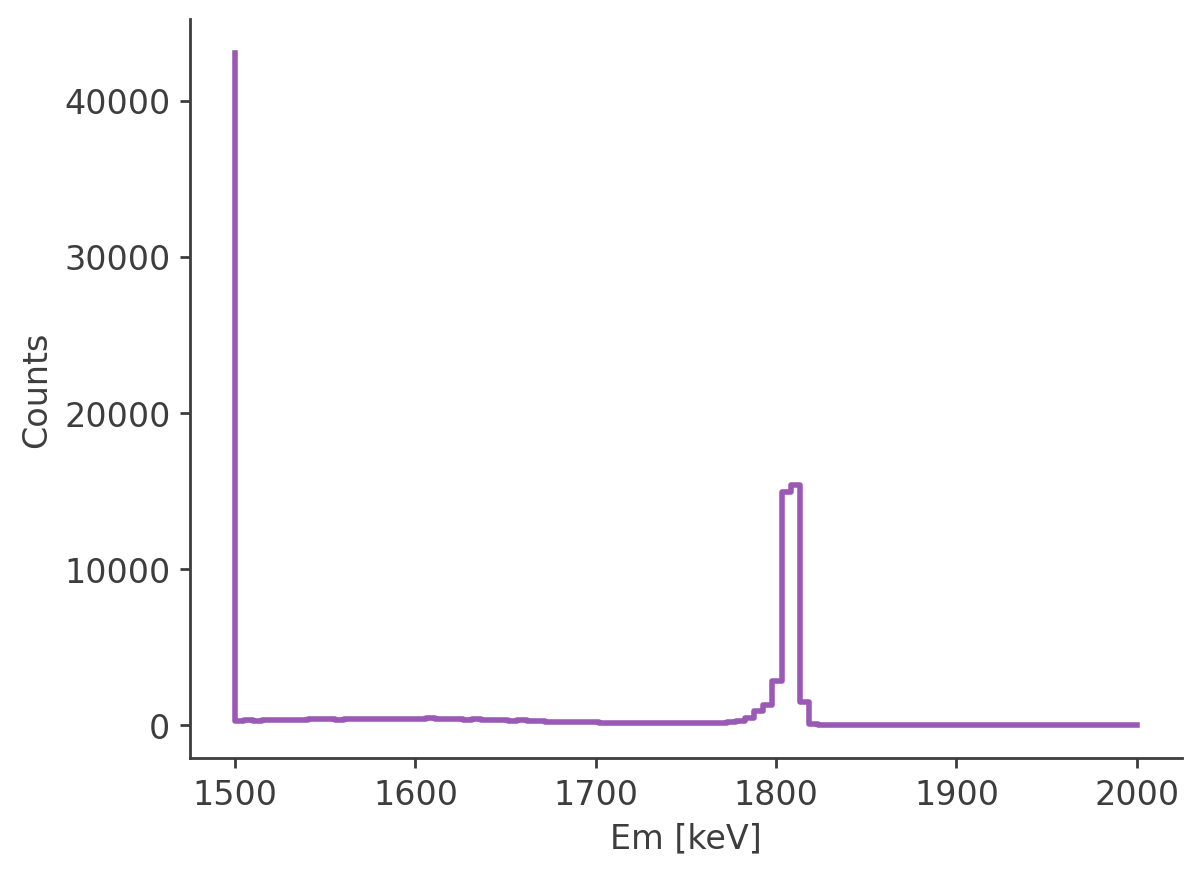

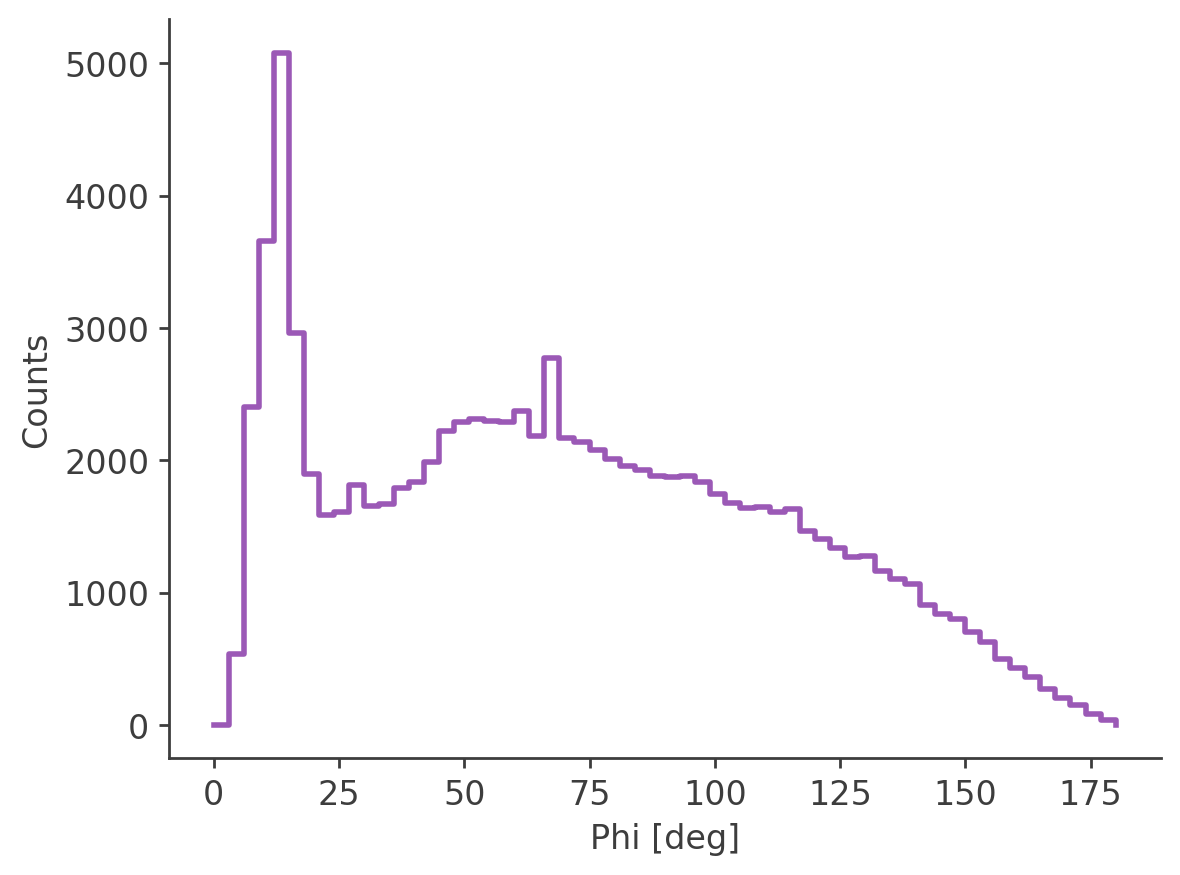

plotting psichi map in galactic...


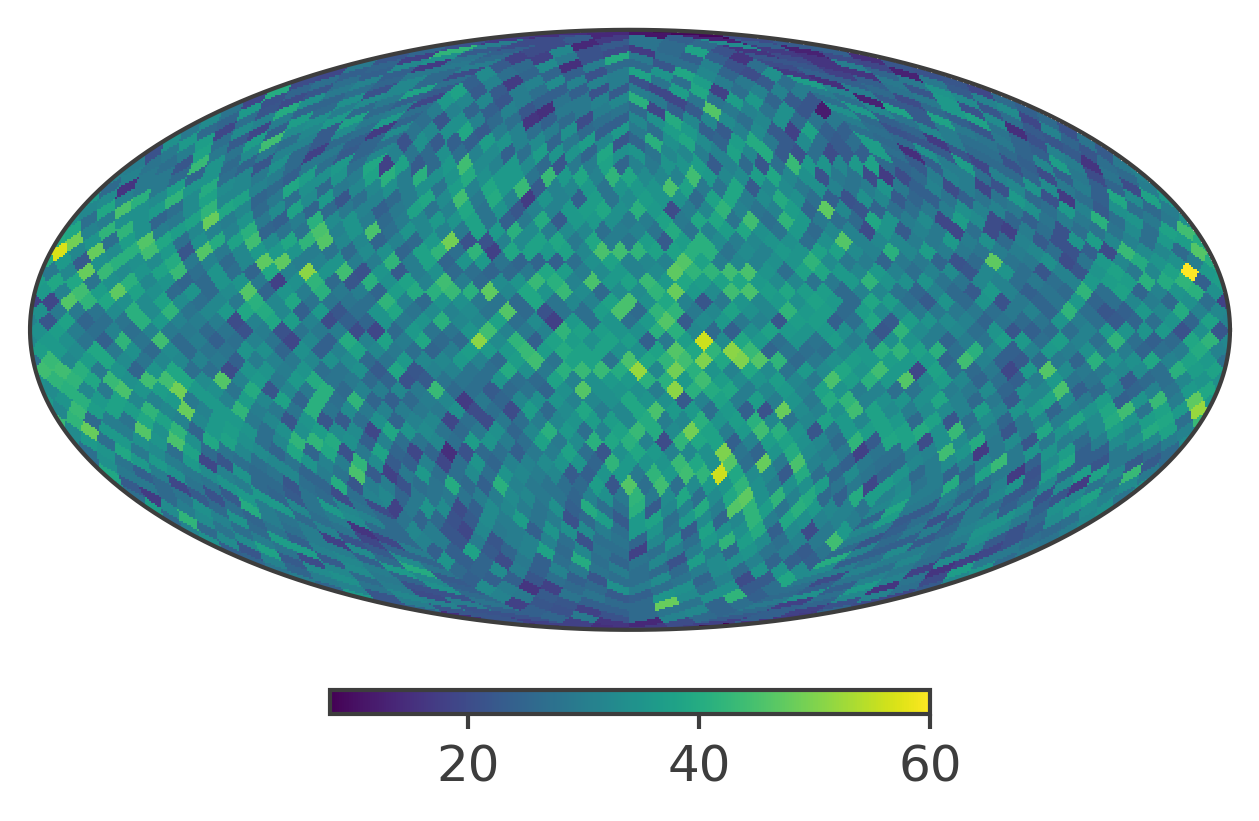

CPU times: user 4.95 s, sys: 102 ms, total: 5.05 s
Wall time: 3.28 s


In [8]:
%%time

#path to unbinned fits file for source and background to create binned dataset
spectrum_Al.get_binned_data(unbinned_data=path_to_Al, make_binning_plots=True, 
            output_name='Al_binned', show_plots=True)

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


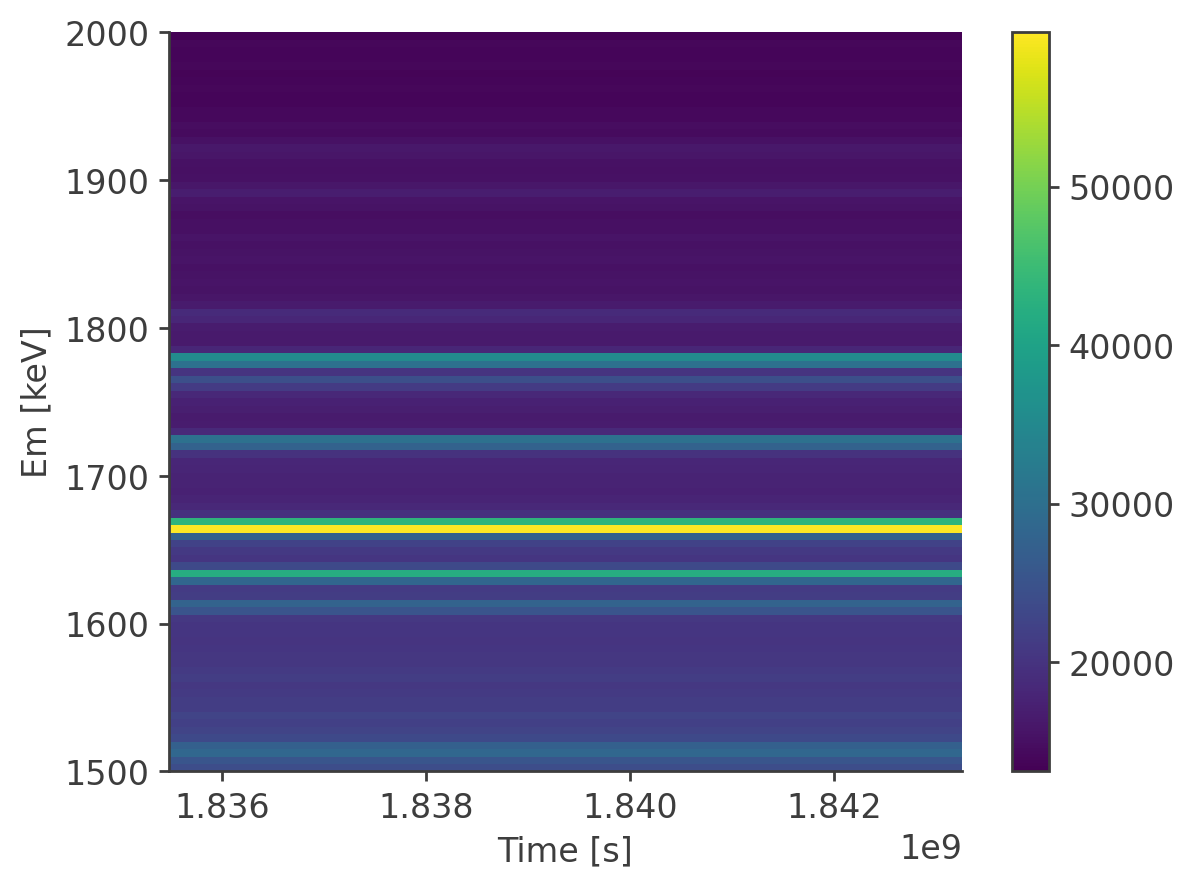

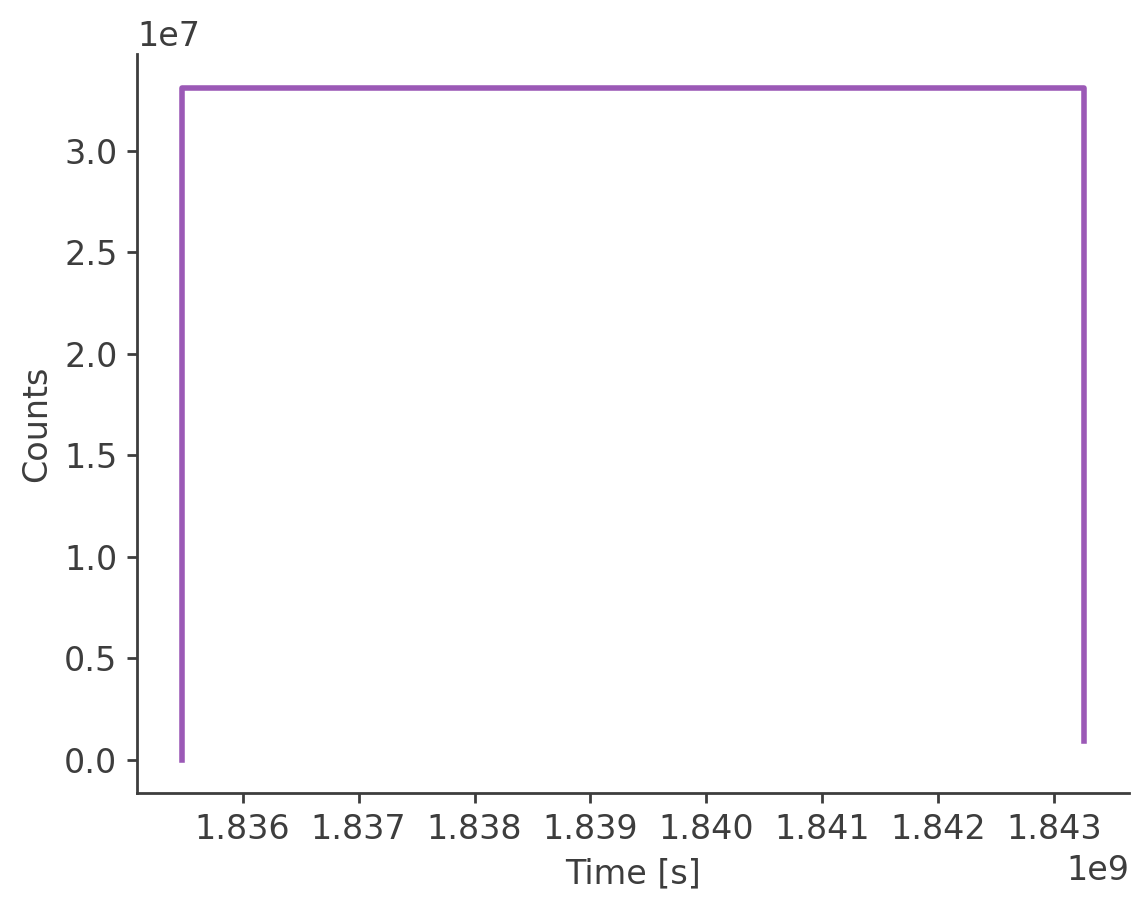

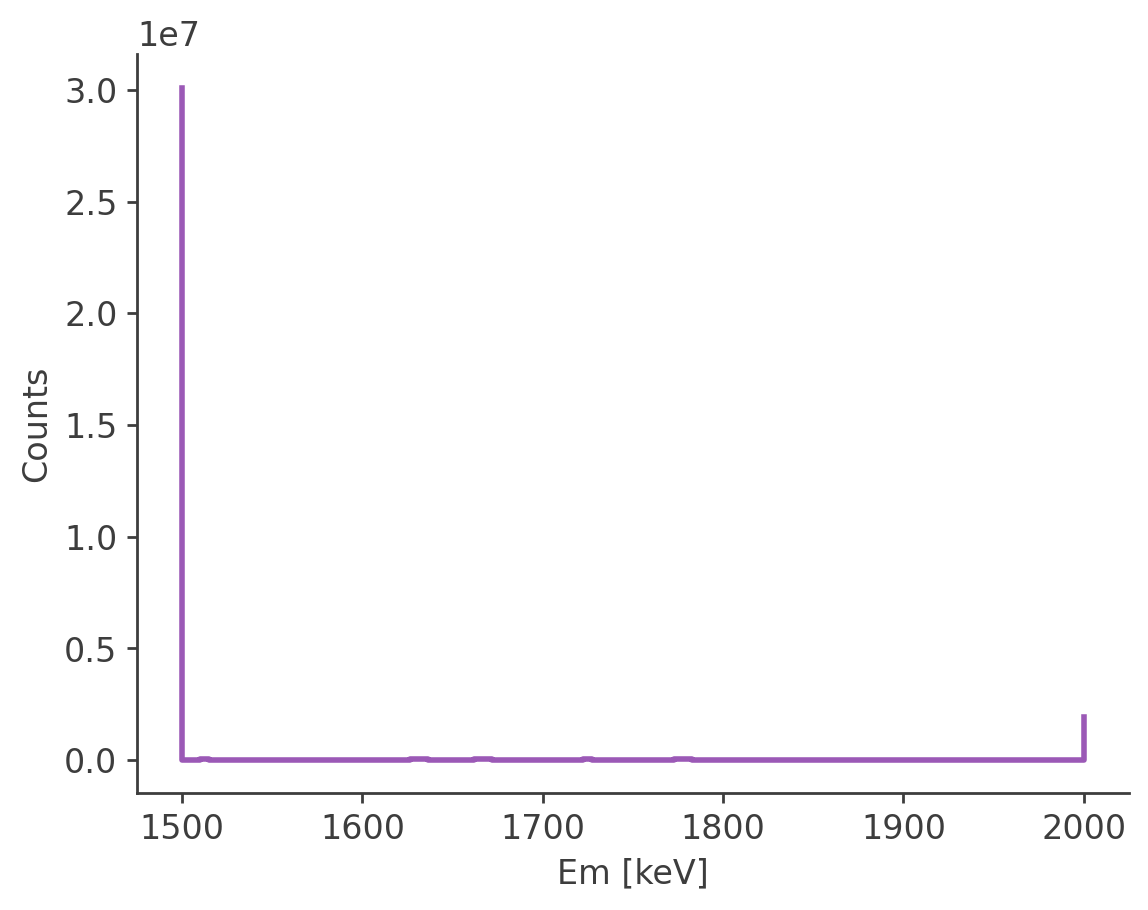

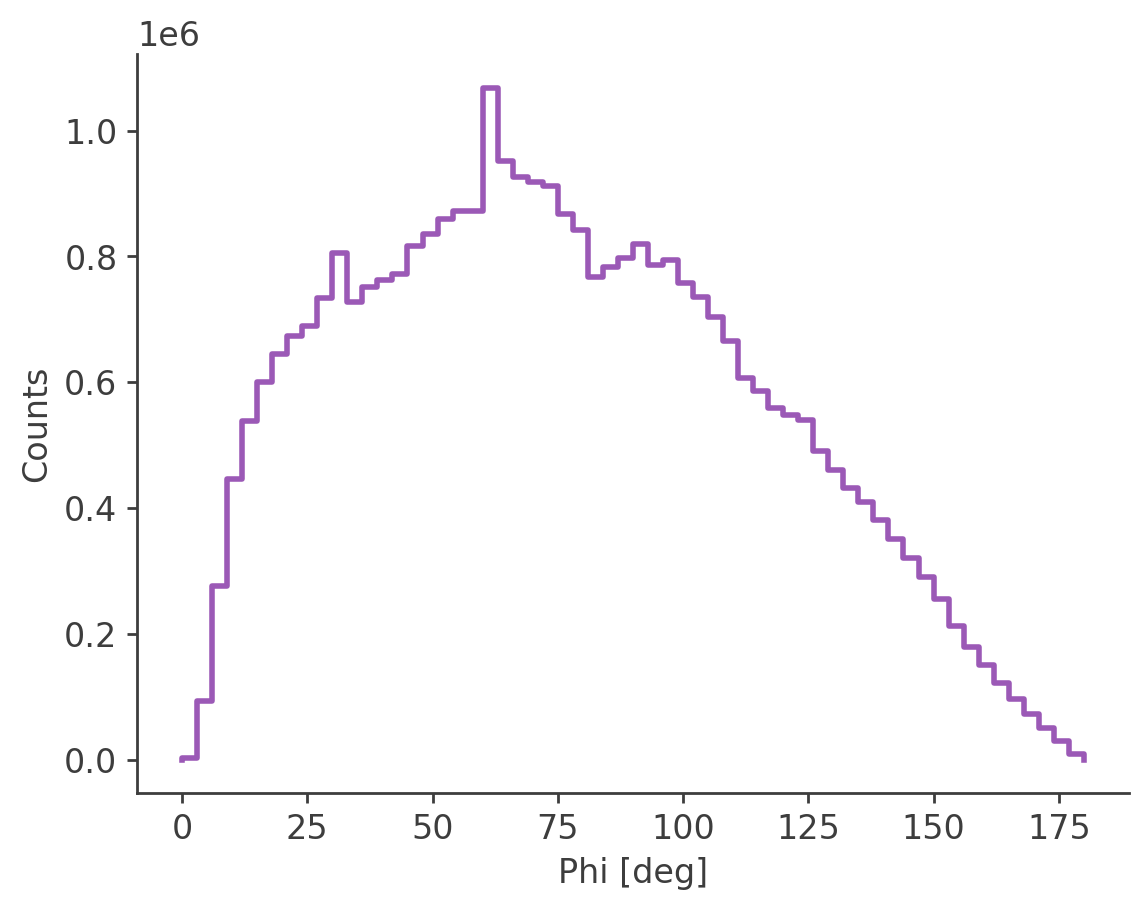

plotting psichi map in galactic...


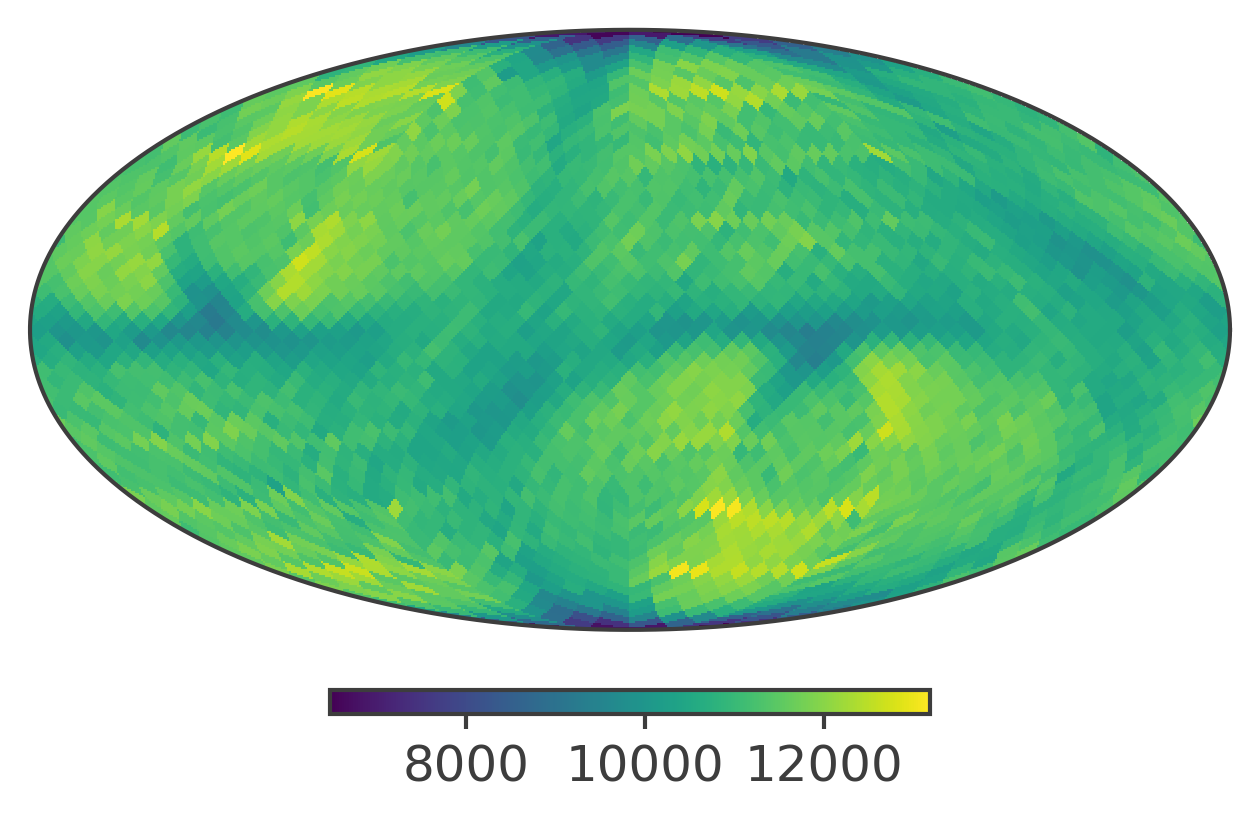

CPU times: user 1min 18s, sys: 3.46 s, total: 1min 21s
Wall time: 1min 19s


In [9]:
%%time

#path to unbinned fits file for source and background to create binned dataset
spectrum_bkg.get_binned_data(unbinned_data=path_to_bkg, make_binning_plots=True, 
            output_name='bkg_binned', show_plots=True)

In [10]:
#combine source and background binned data
spectrum_total = spectrum_Al.binned_data + spectrum_bkg.binned_data
spectrum_total.write('combined_al_bkg_nside_16.hdf5')

This `spectrum_total` can be considered as the actual event histogram in COSI observations.

In [11]:
# load data
spectrum_bkg = Histogram.open("bkg_binned.hdf5")
spectrum_Al = Histogram.open("Al_binned.hdf5")
spectrum_total = Histogram.open("combined_al_bkg_nside_16.hdf5")

## 1. Instantiate the LineBackgroundEstimation

In [12]:
instance = LineBackgroundEstimation(spectrum_total)

## 2. Set background model and fit it

## Define a background spectrum model for fitting data

In [13]:
def powerlaw(x, a, b, pivot):
    return a * (x/pivot)**b

def gaussian(x, a, mu, sigma):
    return a / (sigma) / np.sqrt(2 * np.pi) * np.exp( -(x-mu)**2 / (2*sigma**2))

def bkg_model(x, a, b, a1, mu1, a2, mu2, a3, mu3, a4, mu4, a5, mu5, a6, mu6, sigma):
    pivot = 1800.0
    return powerlaw(x,a,b, pivot) + \
            gaussian(x , a1, mu1, sigma) + \
            gaussian(x , a2, mu2, sigma) + \
            gaussian(x , a3, mu3, sigma) + \
            gaussian(x , a4, mu4, sigma) + \
            gaussian(x , a5, mu5, sigma) + \
            gaussian(x , a6, mu6, sigma)

(<Axes: xlabel='Em [keV]'>, <ErrorbarContainer object of 3 artists>)

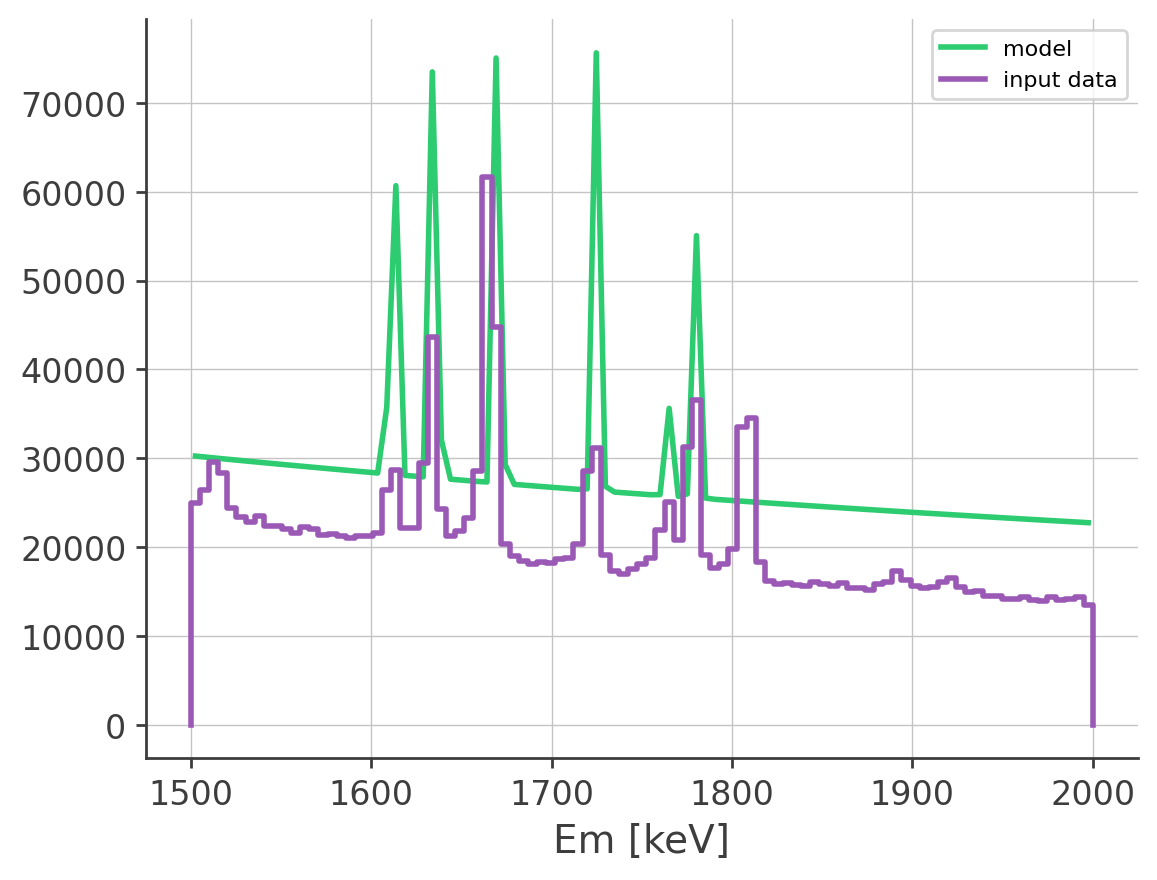

In [14]:
instance.set_bkg_energy_spectrum_model(bkg_model, [5000.0, -1.0, 40000.0, 1612, 50000.0, 1635, 50000.0, 1670, 50000.0, 1725, 10000.0, 1765, 30000.0, 1780, 1.0])
instance.plot_energy_spectrum()

In [15]:
%%time

m = instance.fit_energy_spectrum()
m


WARNING RuntimeWarning: invalid value encountered in log


WARNING IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log



CPU times: user 1min 34s, sys: 374 ms, total: 1min 34s
Wall time: 1min 34s


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.859e+07                 │             Nfcn = 5834              │
│ EDM = 1.24e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 3.4912e3  │ 0.0031e3  │            │            │         │         │       │
│ 1 │ x1   │  -1.898   │   0.009   │            │            │         │         │       │
│ 2 │ x2   │  12.67e3  │  0.26e3   │            │            │         │         │       │
│ 3 │ x3   │ 1.61200e3 │ 0.00008e3 │            │            │         │         │       │
│ 4 │ x4   │  35.41e3  │  0.31e3   │            │            │         │         │       │
│ 5 │ x5   │1.633136e3 │0.000034e3 │            │            │         │         │       │
│ 6 │ x6   │  73.6e3   │   0.4e3   │            │            │         │         │       │
│ 7 │ x7   │1.665443e3 │0.000020e3 │            │            │         │         │       │
│ 8 │ x8   │  23.16e3  │  0.27e3   │            │            │         │         │       │
│ 9 │ x9   │ 1.72263e3 │ 0.00004e3 │            │            │         │         │       │
│ 10│ x10  │  11.85e3  │  0.24e3   │            │            │         │         │       │
│ 11│ x11  │ 1.76417e3 │ 0.00010e3 │            │            │         │         │       │
│ 12│ x12  │  34.47e3  │  0.29e3   │            │            │         │         │       │
│ 13│ x13  │1.778390e3 │0.000032e3 │            │            │         │         │       │
│ 14│ x14  │   2.852   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14 │
├─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │      9.68  11.30e-3       -90    -0.001      -120   -0.0009      -169    2.6e-3      -124    0.0006      -121     0.004      -143   -0.0011  -9.16e-3 │
│  x1 │  11.30e-3  8.11e-05 304.61e-3  -0.01e-3 274.36e-3        -0 233.90e-3        -0  35.26e-3        -0 -55.03e-3        -0 -69.24e-3        -0   0.01e-3 │
│  x2 │       -90 304.61e-3  6.75e+04    -0.880         0    0.0421    0.01e6 -145.8e-3         0   -0.0295         0    -0.085         0    0.0457 510.72e-3 │
│  x3 │    -0.001  -0.01e-3    -0.880   0.00666     0.214    0.0000     0.451        -0     0.136   -0.0000     0.096    -0.000     0.205    0.0000   0.06e-3 │
│  x4 │      -120 274.36e-3         0     0.214   9.4e+04   -0.0917    0.01e6 -309.9e-3         0   -0.0455         0    -0.110    0.01e6    0.1058   1.12303 │
│  x5 │   -0.0009        -0    0.0421    0.0000   -0.0917   0.00118    0.2172  

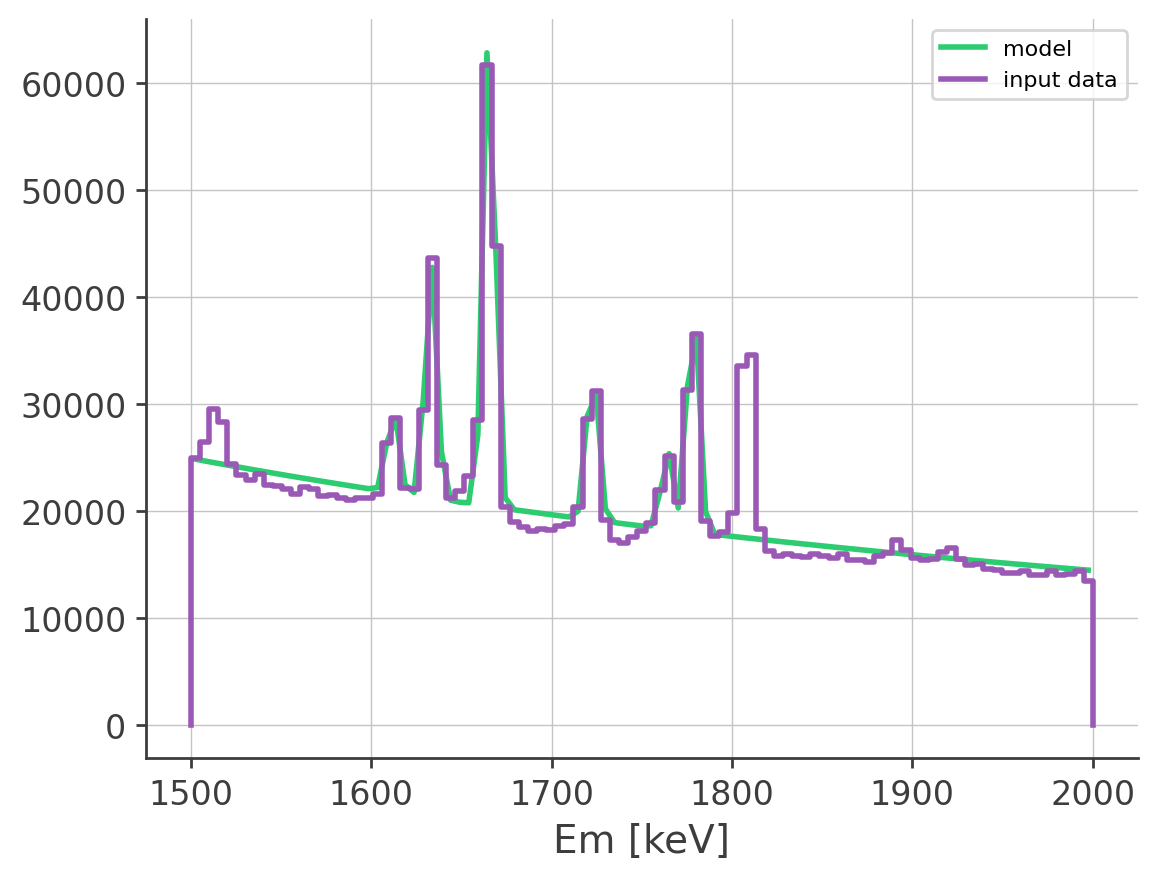

In [16]:
ax, _ = instance.plot_energy_spectrum()

## Mask a region around Al-26

In [17]:
instance.set_mask((1790.0, 1825.0) * u.keV)
instance.mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [18]:
m = instance.fit_energy_spectrum()
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.703e+07                 │             Nfcn = 1237              │
│ EDM = 7.59e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 3.3819e3  │ 0.0033e3  │            │            │         │         │       │
│ 1 │ x1   │  -2.038   │   0.009   │            │            │         │         │       │
│ 2 │ x2   │  13.65e3  │  0.26e3   │            │            │         │         │       │
│ 3 │ x3   │ 1.61201e3 │ 0.00008e3 │            │            │         │         │       │
│ 4 │ x4   │  36.72e3  │  0.31e3   │            │            │         │         │       │
│ 5 │ x5   │1.633145e3 │0.000034e3 │            │            │         │         │       │
│ 6 │ x6   │  75.4e3   │   0.4e3   │            │            │         │         │       │
│ 7 │ x7   │1.665418e3 │0.000020e3 │            │            │         │         │       │
│ 8 │ x8   │  24.57e3  │  0.27e3   │            │            │         │         │       │
│ 9 │ x9   │ 1.72262e3 │ 0.00004e3 │            │            │         │         │       │
│ 10│ x10  │  13.23e3  │  0.24e3   │            │            │         │         │       │
│ 11│ x11  │ 1.76412e3 │ 0.00009e3 │            │            │         │         │       │
│ 12│ x12  │  36.11e3  │  0.29e3   │            │            │         │         │       │
│ 13│ x13  │1.778402e3 │0.000033e3 │            │            │         │         │       │
│ 14│ x14  │   2.954   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14 │
├─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │      10.7  13.18e-3      -104    -0.002      -137   -0.0007      -193    2.3e-3      -145    0.0008      -139     0.005      -166   -0.0013 -10.54e-3 │
│  x1 │  13.18e-3  8.55e-05 297.72e-3  -0.01e-3 257.55e-3        -0 203.37e-3        -0  12.09e-3        -0 -81.45e-3        -0 -99.64e-3        -0   0.01e-3 │
│  x2 │      -104 297.72e-3  6.95e+04    -0.646    0.01e6    0.0283    0.01e6 -126.9e-3         0   -0.0447         0    -0.158         0    0.0444 569.48e-3 │
│  x3 │    -0.002  -0.01e-3    -0.646   0.00652     0.201    0.0000     0.414        -0     0.147   -0.0000     0.099    -0.000     0.205    0.0000   0.06e-3 │
│  x4 │      -137 257.55e-3    0.01e6     0.201  9.62e+04   -0.0826    0.01e6 -240.6e-3    0.01e6   -0.0735         0    -0.256    0.01e6    0.0904   1.12245 │
│  x5 │   -0.0007        -0    0.0283    0.0000   -0.0826   0.00116    0.1326  

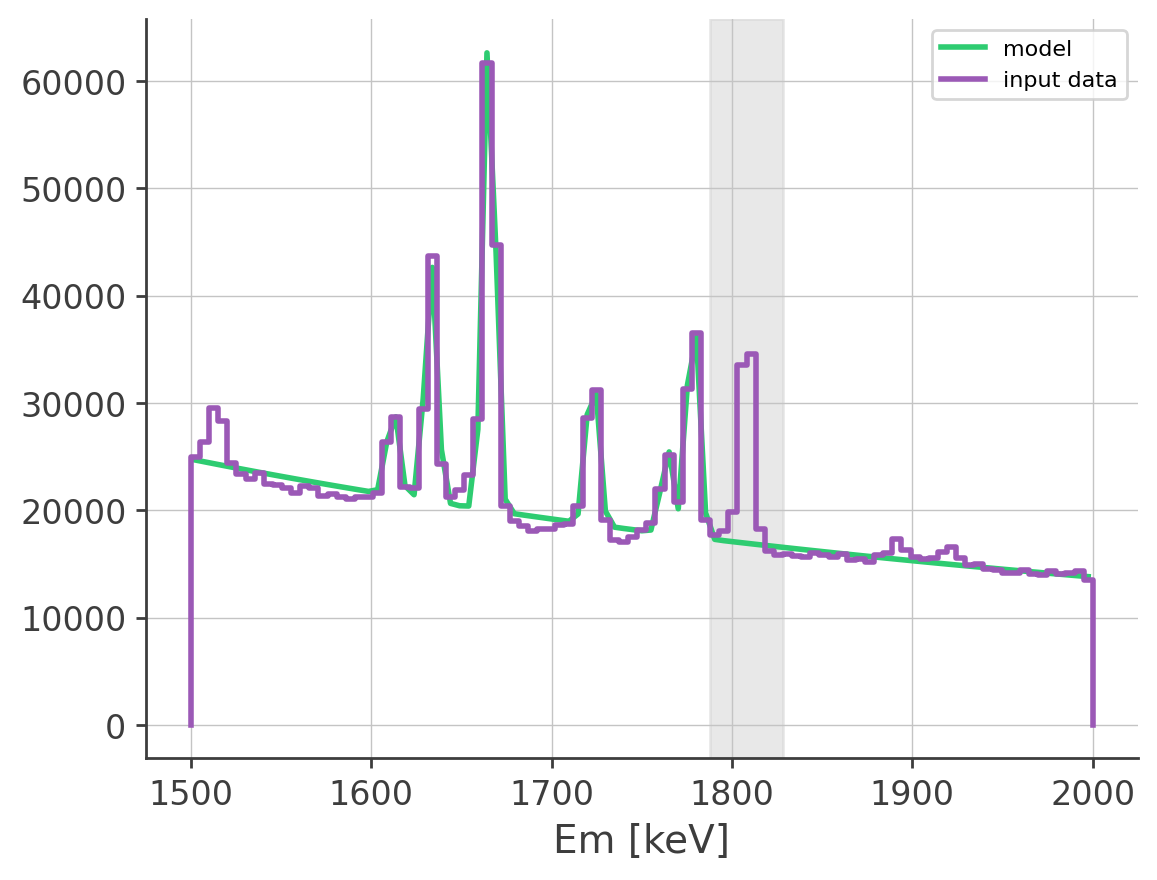

In [19]:
ax, _ = instance.plot_energy_spectrum()

## Mask more

In [20]:
instance.set_mask((1500.0, 1550.0) * u.keV, (1790.0, 1825.0) * u.keV, (1880.0, 2000.0) * u.keV)
instance.mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [21]:
m = instance.fit_energy_spectrum()
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.166e+07                 │              Nfcn = 630              │
│ EDM = 0.000275 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  3.306e3  │  0.006e3  │            │            │         │         │       │
│ 1 │ x1   │  -2.021   │   0.019   │            │            │         │         │       │
│ 2 │ x2   │  15.10e3  │  0.27e3   │            │            │         │         │       │
│ 3 │ x3   │ 1.61202e3 │ 0.00008e3 │            │            │         │         │       │
│ 4 │ x4   │  38.40e3  │  0.32e3   │            │            │         │         │       │
│ 5 │ x5   │1.633147e3 │0.000034e3 │            │            │         │         │       │
│ 6 │ x6   │  77.5e3   │   0.4e3   │            │            │         │         │       │
│ 7 │ x7   │1.665395e3 │0.000020e3 │            │            │         │         │       │
│ 8 │ x8   │  25.93e3  │  0.28e3   │            │            │         │         │       │
│ 9 │ x9   │ 1.72261e3 │ 0.00005e3 │            │            │         │         │       │
│ 10│ x10  │  14.37e3  │  0.25e3   │            │            │         │         │       │
│ 11│ x11  │ 1.76406e3 │ 0.00009e3 │            │            │         │         │       │
│ 12│ x12  │  37.48e3  │  0.30e3   │            │            │         │         │       │
│ 13│ x13  │1.778412e3 │0.000033e3 │            │            │         │         │       │
│ 14│ x14  │   3.064   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14 │
├─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │      31.9   76.5e-3      -102    -0.008      -198   -0.0021      -358    2.9e-3      -351    0.0011      -380     0.014      -456   -0.0037 -21.88e-3 │
│  x1 │   76.5e-3  0.000363  887.1e-3        -0  648.5e-3        -0  296.5e-3        -0 -325.5e-3        -0 -673.7e-3         0 -807.7e-3        -0         0 │
│  x2 │      -102  887.1e-3  7.53e+04    -0.438    0.01e6    0.0022    0.01e6 -146.1e-3    0.01e6   -0.0994         0    -0.362         0    0.0375 825.62e-3 │
│  x3 │    -0.008        -0    -0.438   0.00621     0.185    0.0000     0.408        -0     0.201   -0.0000     0.159    -0.000     0.276    0.0000   0.05e-3 │
│  x4 │      -198  648.5e-3    0.01e6     0.185  1.02e+05   -0.0867    0.02e6 -224.4e-3    0.01e6   -0.1389    0.01e6    -0.544    0.01e6    0.0746   1.35730 │
│  x5 │   -0.0021        -0    0.0022    0.0000   -0.0867   0.00114    0.0614  

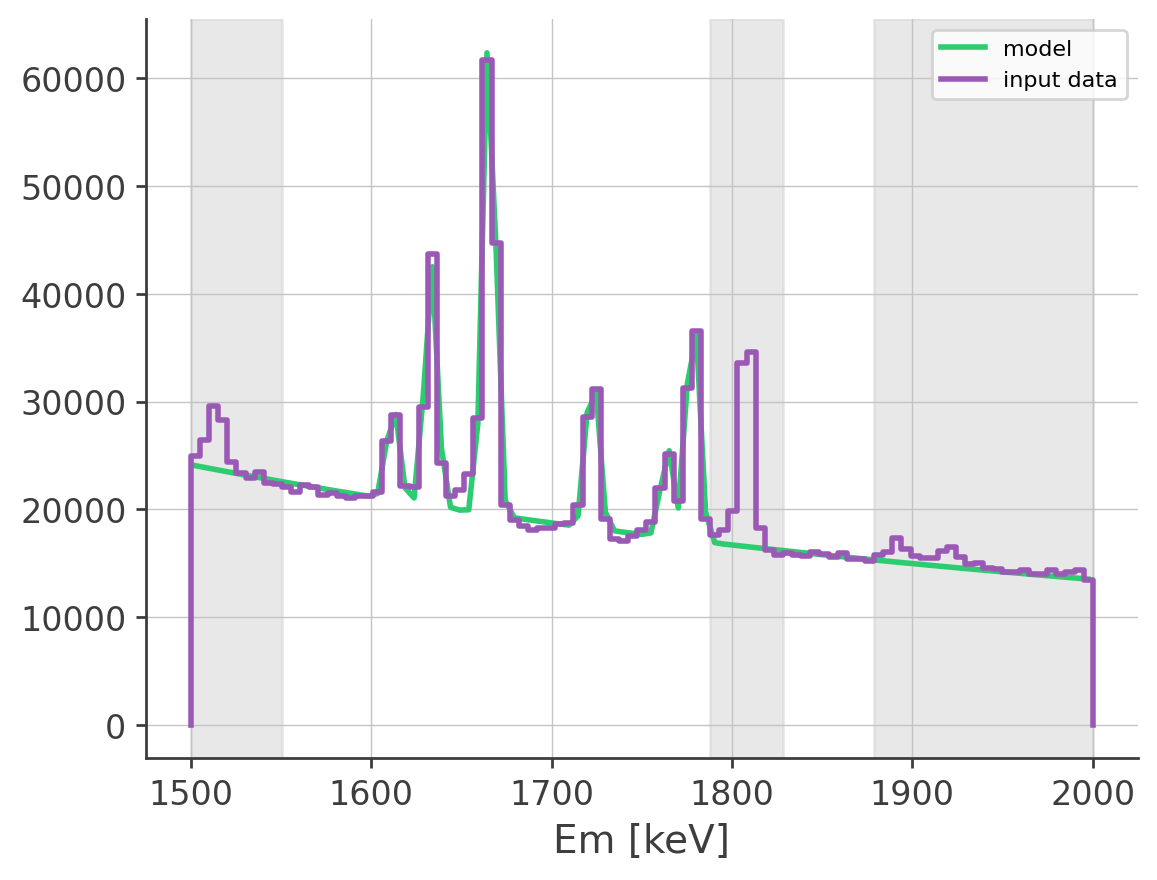

In [22]:
ax, _ = instance.plot_energy_spectrum()

## 3. Generate Background Histogram

In [23]:
source_range = (1805, 1812)  * u.keV #counts estimation in Al26 line

background_region_1 = (1680, 1710) * u.keV #background counts estimation before the line
background_region_2 = (1840, 1875) * u.keV #background counts estimation before the line
background_region_3 = (1940, 1980) * u.keV #background counts estimation before the line

In [24]:
bkg_model_histogram = instance.generate_bkg_model_histogram(source_range, [background_region_1, background_region_2, background_region_3])

The energy range [1680. 1710.] is modified to [1681.81818182, 1707.07070707]
The energy range [1840. 1875.] is modified to [1843.43434343, 1873.73737374]
The energy range [1940. 1980.] is modified to [1944.44444444, 1979.7979798]


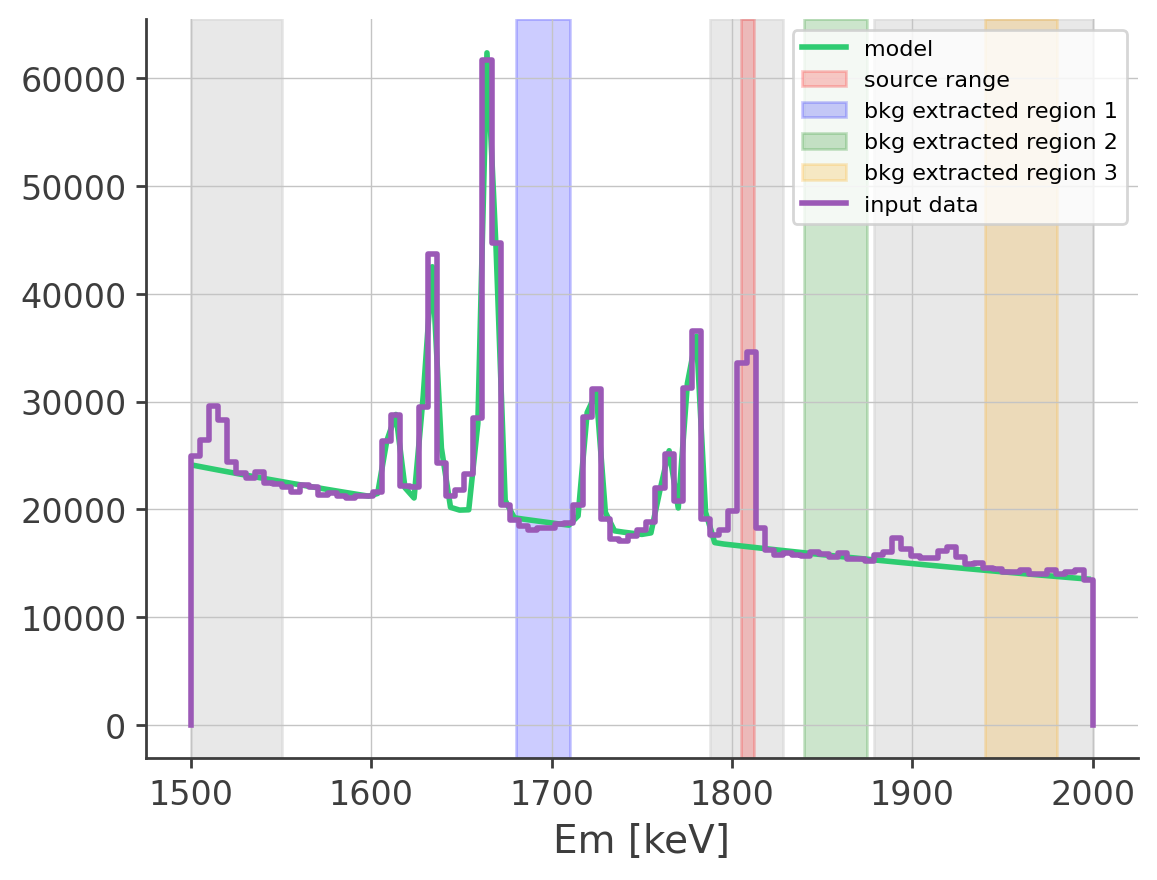

In [25]:
ax, _ = instance.plot_energy_spectrum()

ax.axvspan(source_range[0].value, source_range[1].value, color='red', alpha=0.2, label = 'source range')

ax.axvspan(background_region_1[0].value, background_region_1[1].value, color='blue', alpha=0.2, label = 'bkg extracted region 1')
ax.axvspan(background_region_2[0].value, background_region_2[1].value, color='green', alpha=0.2, label = 'bkg extracted region 2')
ax.axvspan(background_region_3[0].value, background_region_3[1].value, color='orange', alpha=0.2, label = 'bkg extracted region 3')

ax.legend()

In [26]:
bkg_model_histogram.write('bkg_model_al26_line.hdf5', overwrite=True)

## 4. Compare the background model with the actual background data

In [27]:
%%time

bkg_histogram_in_Al26line = BinnedData("inputs_check_results.yaml")
bkg_histogram_in_Al26line.get_binned_data(unbinned_data=path_to_bkg, make_binning_plots=False, 
                                          output_name='bkg_data_al26_line_for_comparison', show_plots=False)

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None
CPU times: user 1min 10s, sys: 3.13 s, total: 1min 13s
Wall time: 1min 13s


In [28]:
bkg_histogram_in_Al26line = Histogram.open("bkg_data_al26_line_for_comparison.hdf5")

In [29]:
bkg_model_histogram = bkg_model_histogram.todense()
bkg_histogram_in_Al26line = bkg_histogram_in_Al26line.todense()

In [30]:
bkg_model_histogram.clear_underflow_and_overflow()
bkg_histogram_in_Al26line.clear_underflow_and_overflow()

## Normalization

In [31]:
count_model = np.sum(bkg_model_histogram[:])
count_obs = np.sum(bkg_histogram_in_Al26line[:])

print("model:", count_model)
print("data:", count_obs)
print("difference:", (count_obs/count_model - 1)*1e2, "%")

model: 22214.10522101276
data: 26126.0
difference: 17.609958808005022 %


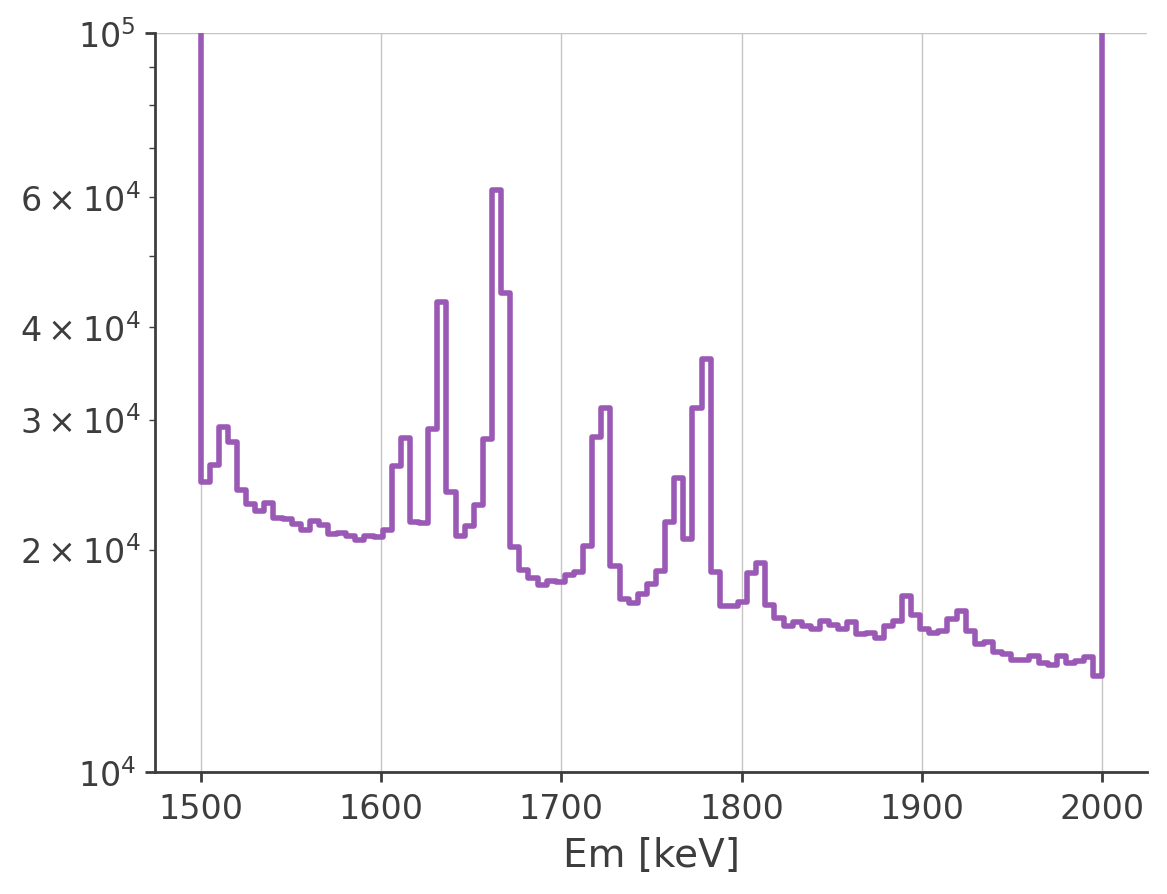

In [32]:
spectrum_bkg.project('Em').draw()
plt.ylim(1e4, 1e5)
plt.yscale('log')
plt.grid()

**The underestimation is caused by the fact that the background also has a line around 1.809 keV**

## Phi distritbuion

In [33]:
bkg_model_phi = bkg_model_histogram.project("Phi").todense()
bkg_obs_phi = bkg_histogram_in_Al26line.project("Phi").todense()


WARNING RuntimeWarning: divide by zero encountered in divide



(-20.0, 20.0)

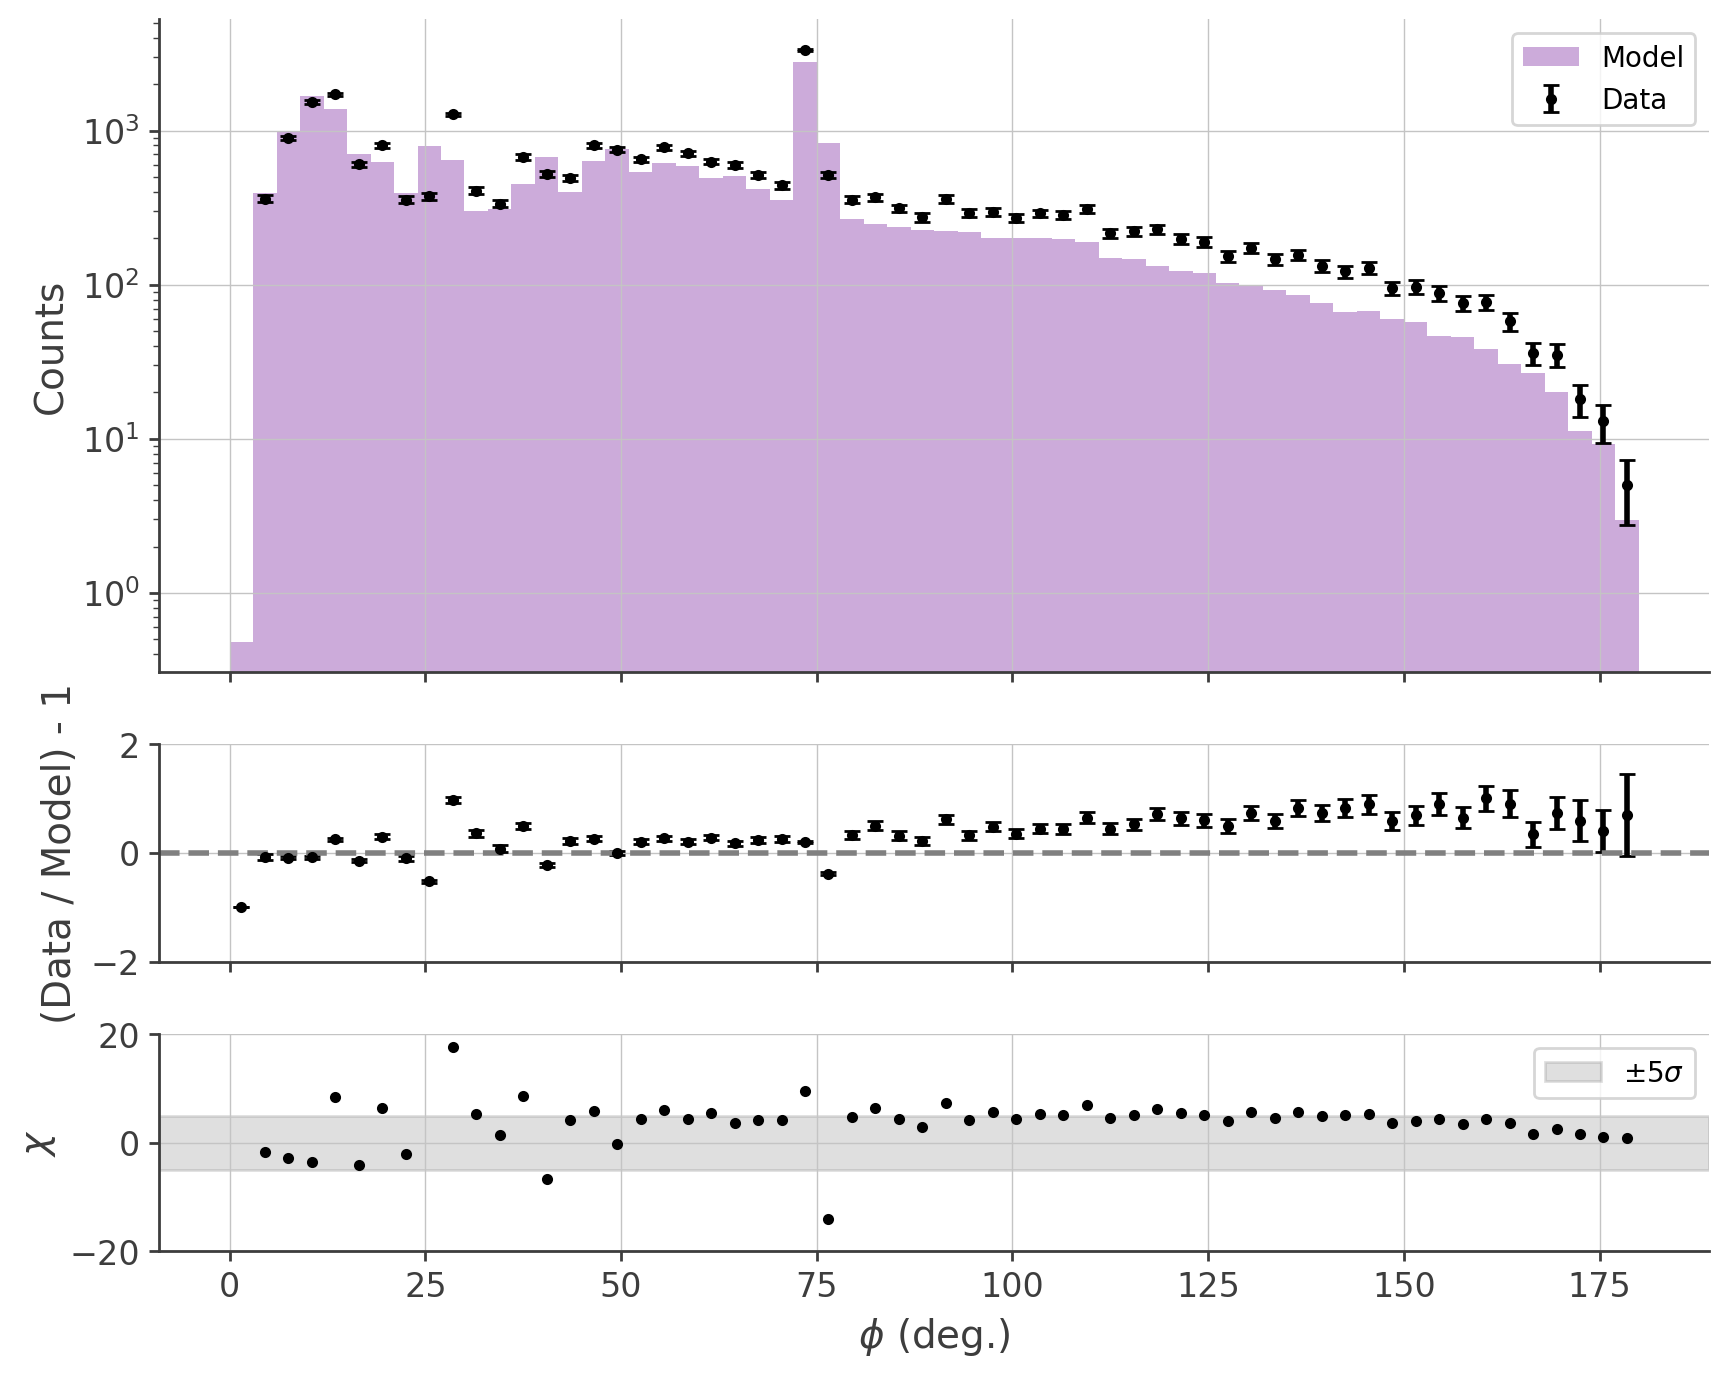

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

ax3.set_xlabel(r'$\phi$ (deg.)')

ax1.bar(bkg_model_phi.axis.centers, bkg_model_phi.contents, width = 3, alpha=0.5, label='Model')
#ax1.bar(bkg_obs_phi.axis.centers,   bkg_obs_phi.contents,   width = 3, alpha=0.5, label='Data', capsize=3, yerr = np.sqrt(bkg_obs_phi.contents))
ax1.errorbar(bkg_obs_phi.axis.centers, bkg_obs_phi.contents, color = 'black', label='Data', fmt='.', capsize=3, yerr = np.sqrt(bkg_obs_phi.contents))
ax1.set_ylabel('Counts')
ax1.legend(fontsize = 10)
ax1.grid()
ax1.set_yscale('log')

# ratio
diff = bkg_obs_phi.contents / bkg_model_phi.contents - 1
diff_err = np.sqrt(bkg_obs_phi.contents) / bkg_model_phi.contents
ax2.errorbar(bkg_model_phi.axis.centers, diff, yerr=diff_err, fmt='.', capsize=3, color = 'black')
ax2.axhline(y = 0, color = 'grey', linestyle = '--')
ax2.grid()
ax2.set_ylabel('(Data / Model) - 1')
ax2.set_ylim(-2, 2)

# chi
xi = (bkg_obs_phi.contents - bkg_model_phi.contents) / np.sqrt(bkg_obs_phi.contents)
ax3.plot(bkg_model_phi.axis.centers, xi, '.', color = 'black')
ax3.axhspan(-5, 5, color = 'grey', alpha = 0.25, label = r"$\pm 5 \sigma$")
ax3.set_ylabel(r"$\chi$")
ax3.grid()
ax3.legend(fontsize = 10)
ax3.set_ylim(-20, 20)

## PsiChi distritbuion

In [35]:
bkg_model_psichi = bkg_model_histogram.project("PsiChi")
bkg_obs_psichi = bkg_histogram_in_Al26line.project("PsiChi")

(-10.0, 10.0)

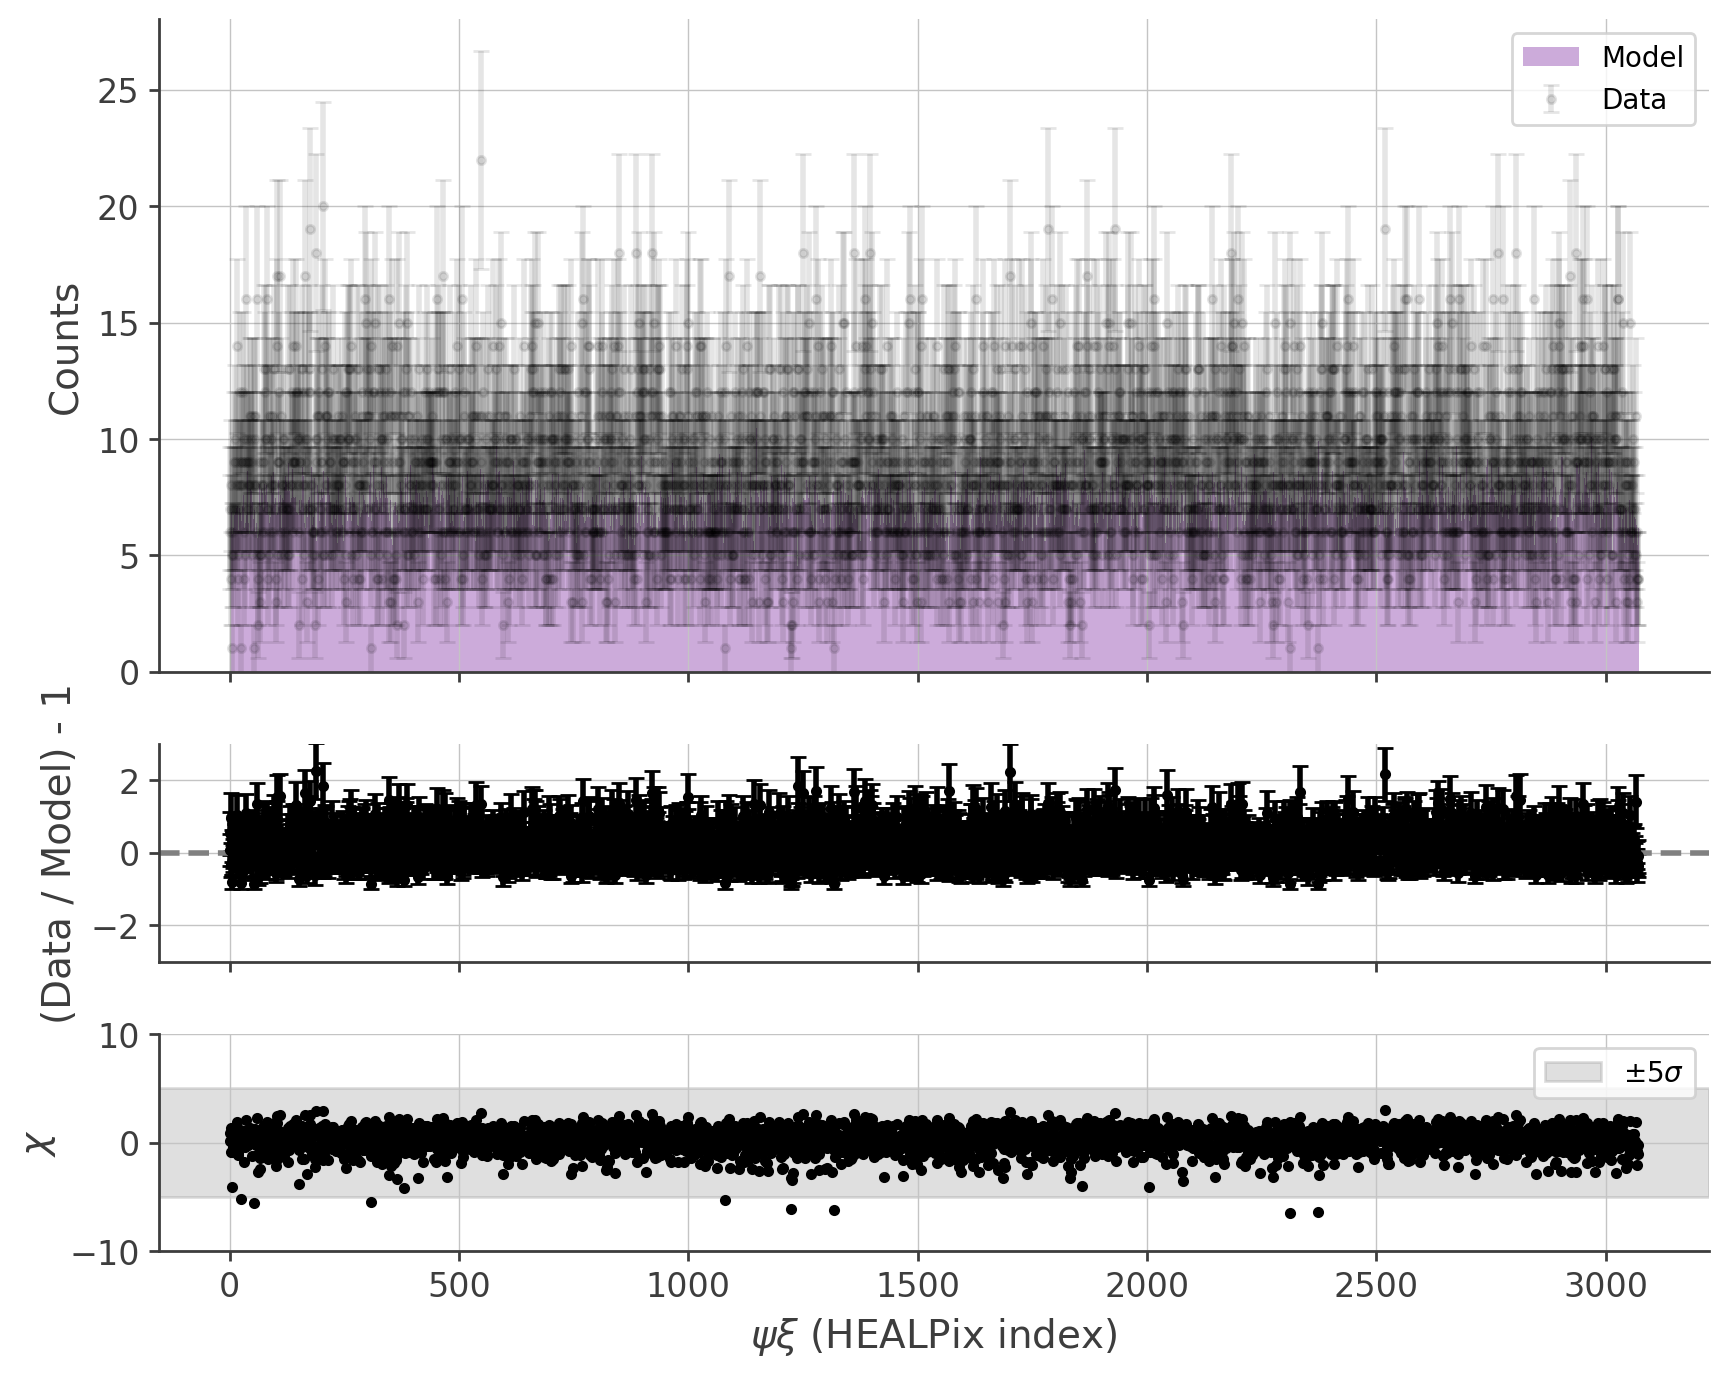

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

ax3.set_xlabel(r'$\psi \xi$ (HEALPix index)')

ax1.bar(bkg_model_psichi.axis.centers, bkg_model_psichi.contents, width = 1, alpha=0.5, label='Model')
#ax1.bar(bkg_obs_psichi.axis.centers,   bkg_obs_psichi.contents,   width = 3, alpha=0.5, label='Data')#, capsize=3, yerr = np.sqrt(bkg_obs_psichi.contents))
ax1.errorbar(bkg_obs_psichi.axis.centers, bkg_obs_psichi.contents, color = 'black', alpha=0.1, label='Data', fmt='.', capsize=3, yerr = np.sqrt(bkg_obs_psichi.contents))
ax1.set_ylabel('Counts')
ax1.legend(fontsize = 10)
ax1.grid()
#ax1.set_yscale('log')

# ratio
diff = bkg_obs_psichi.contents / bkg_model_psichi.contents - 1
diff_err = np.sqrt(bkg_obs_psichi.contents) / bkg_model_psichi.contents
ax2.errorbar(bkg_model_psichi.axis.centers, diff, yerr=diff_err, fmt='.', capsize=3, color = 'black')
ax2.axhline(y = 0, color = 'grey', linestyle = '--')
ax2.grid()
ax2.set_ylabel('(Data / Model) - 1')
ax2.set_ylim(-3, 3)

# chi
xi = (bkg_obs_psichi.contents - bkg_model_psichi.contents) / np.sqrt(bkg_obs_psichi.contents)
ax3.plot(bkg_model_psichi.axis.centers, xi, '.', color = 'black')
ax3.axhspan(-5, 5, color = 'grey', alpha = 0.25, label = r"$\pm 5 \sigma$")
ax3.set_ylabel(r"$\chi$")
ax3.grid()
ax3.legend(fontsize = 10)
ax3.set_ylim(-10, 10)

### Rebinning

In [37]:
import healpy as hp

In [38]:
nside_out = 4

bkg_model_psichi_rebinned = hp.ud_grade(bkg_model_psichi[:], nside_out, power = -2)
bkg_obs_psichi_rebinned   = hp.ud_grade(bkg_obs_psichi[:],   nside_out, power = -2)

(-10.0, 10.0)

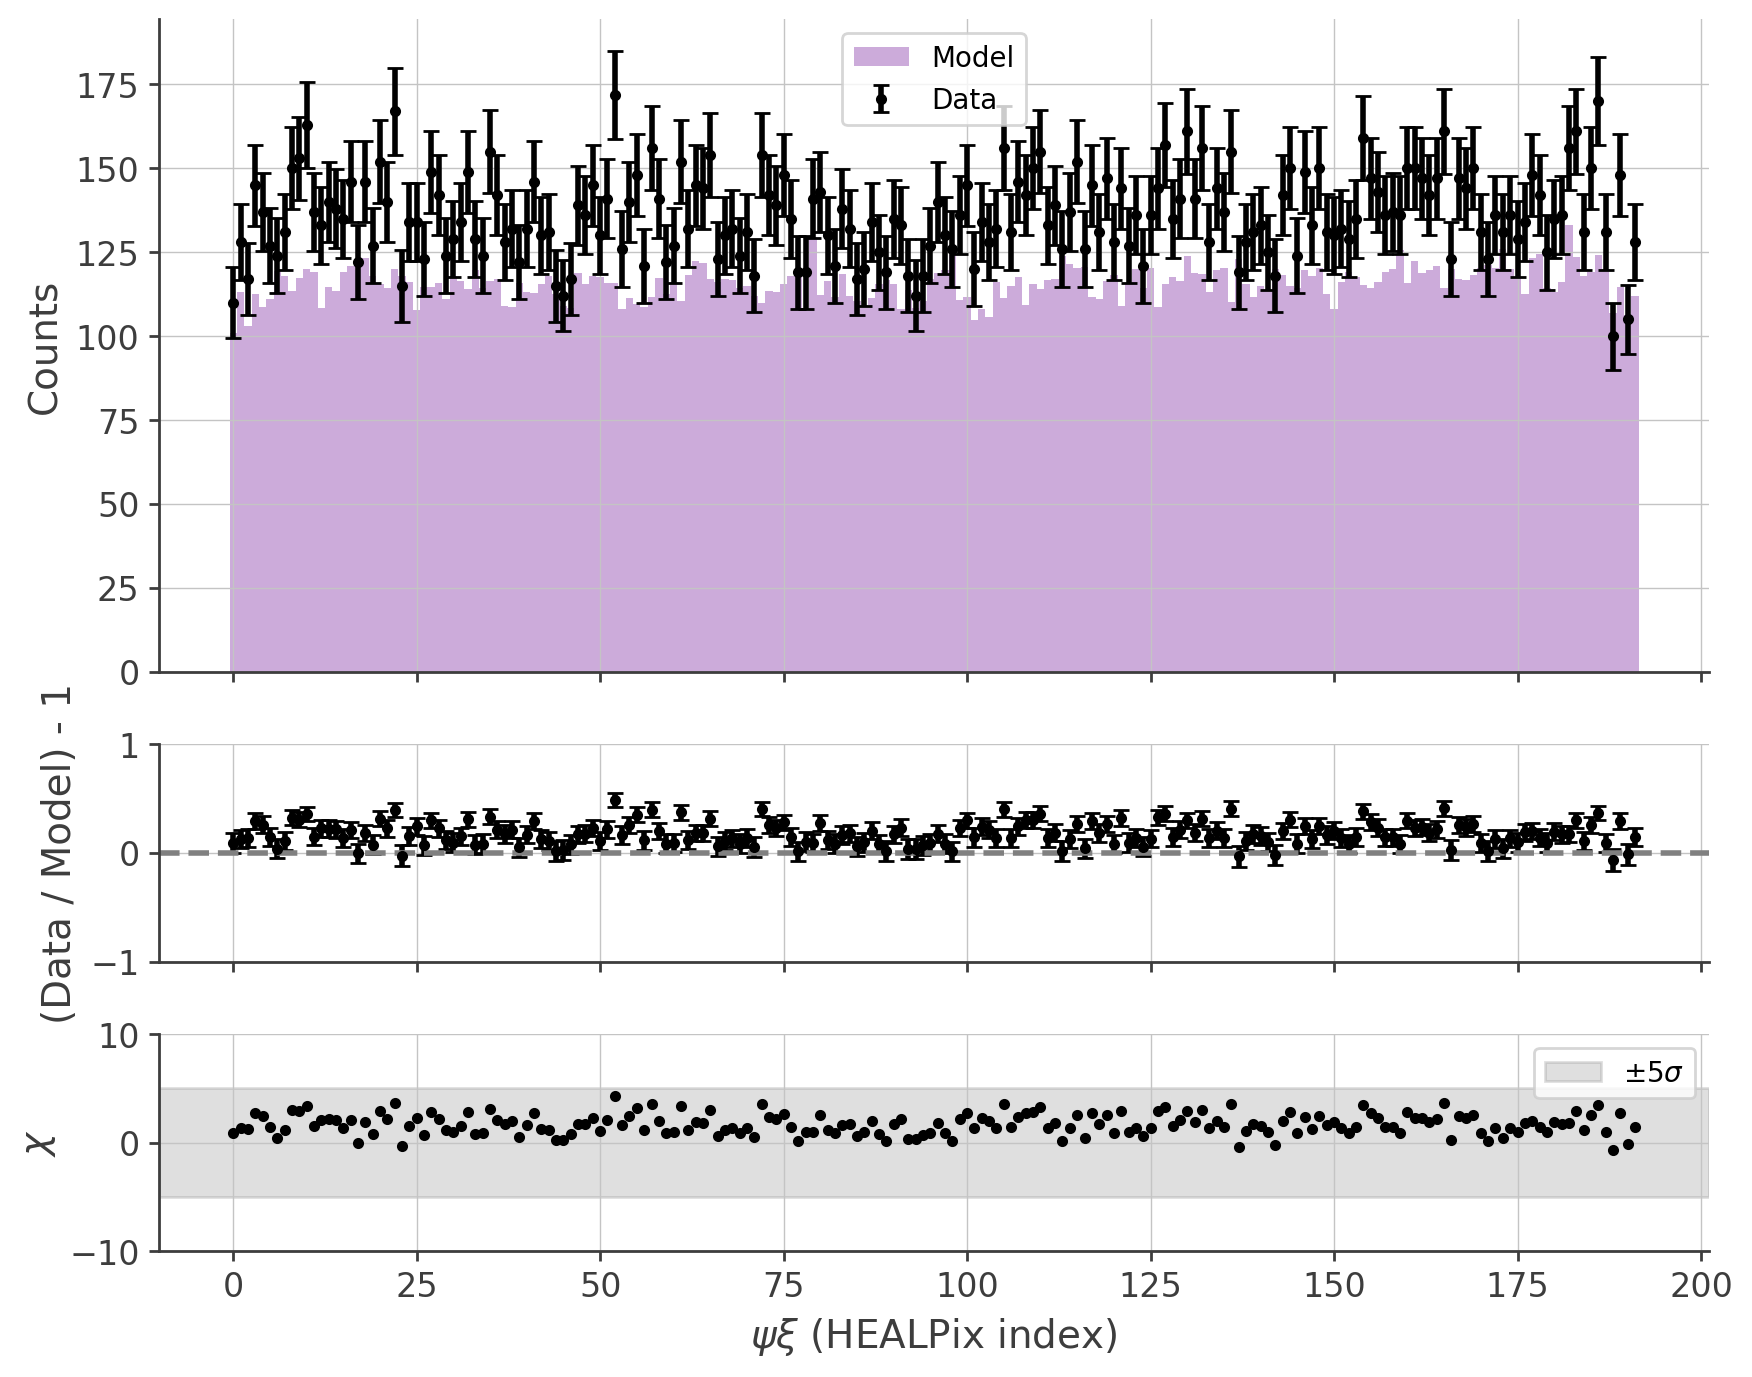

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

ax3.set_xlabel(r'$\psi \xi$ (HEALPix index)')

ax1.bar(np.arange(hp.nside2npix(nside_out)), bkg_model_psichi_rebinned, width = 1, alpha=0.5, label='Model')
#ax1.bar(np.arange(hp.nside2npix(nside_out)), bkg_obs_psichi_rebinned,   width = 3, alpha=0.5, label='Data', capsize=3, yerr = np.sqrt(bkg_obs_psichi_rebinned))
ax1.errorbar(np.arange(hp.nside2npix(nside_out)), bkg_obs_psichi_rebinned, color = 'black', alpha=1, label='Data', fmt='.', capsize=3, yerr = np.sqrt(bkg_obs_psichi_rebinned))
ax1.set_ylabel('Counts')
ax1.legend(fontsize = 10)
ax1.grid()
#ax1.set_yscale('log')

# ratio
diff = bkg_obs_psichi_rebinned / bkg_model_psichi_rebinned - 1
diff_err = np.sqrt(bkg_model_psichi_rebinned) / bkg_obs_psichi_rebinned
ax2.errorbar(np.arange(hp.nside2npix(nside_out)), diff, yerr=diff_err, fmt='.', capsize=3, color = 'black')
ax2.axhline(y = 0, color = 'grey', linestyle = '--')
ax2.grid()
ax2.set_ylabel('(Data / Model) - 1')
ax2.set_ylim(-1, 1)

# chi
xi = (bkg_obs_psichi_rebinned - bkg_model_psichi_rebinned) / np.sqrt(bkg_obs_psichi_rebinned)
ax3.plot(np.arange(hp.nside2npix(nside_out)), xi, '.', color = 'black')
ax3.axhspan(-5, 5, color = 'grey', alpha = 0.25, label = r"$\pm 5 \sigma$")
ax3.set_ylabel(r"$\chi$")
ax3.grid()
ax3.legend(fontsize = 10)
ax3.set_ylim(-10, 10)

As an future idea, applying the smoothing to the background model would be useful to mitigate the Poisson fluctutation in the backgroud model. Note that the smoothing also loses high-frequency information, so there should be optimized in some ways.

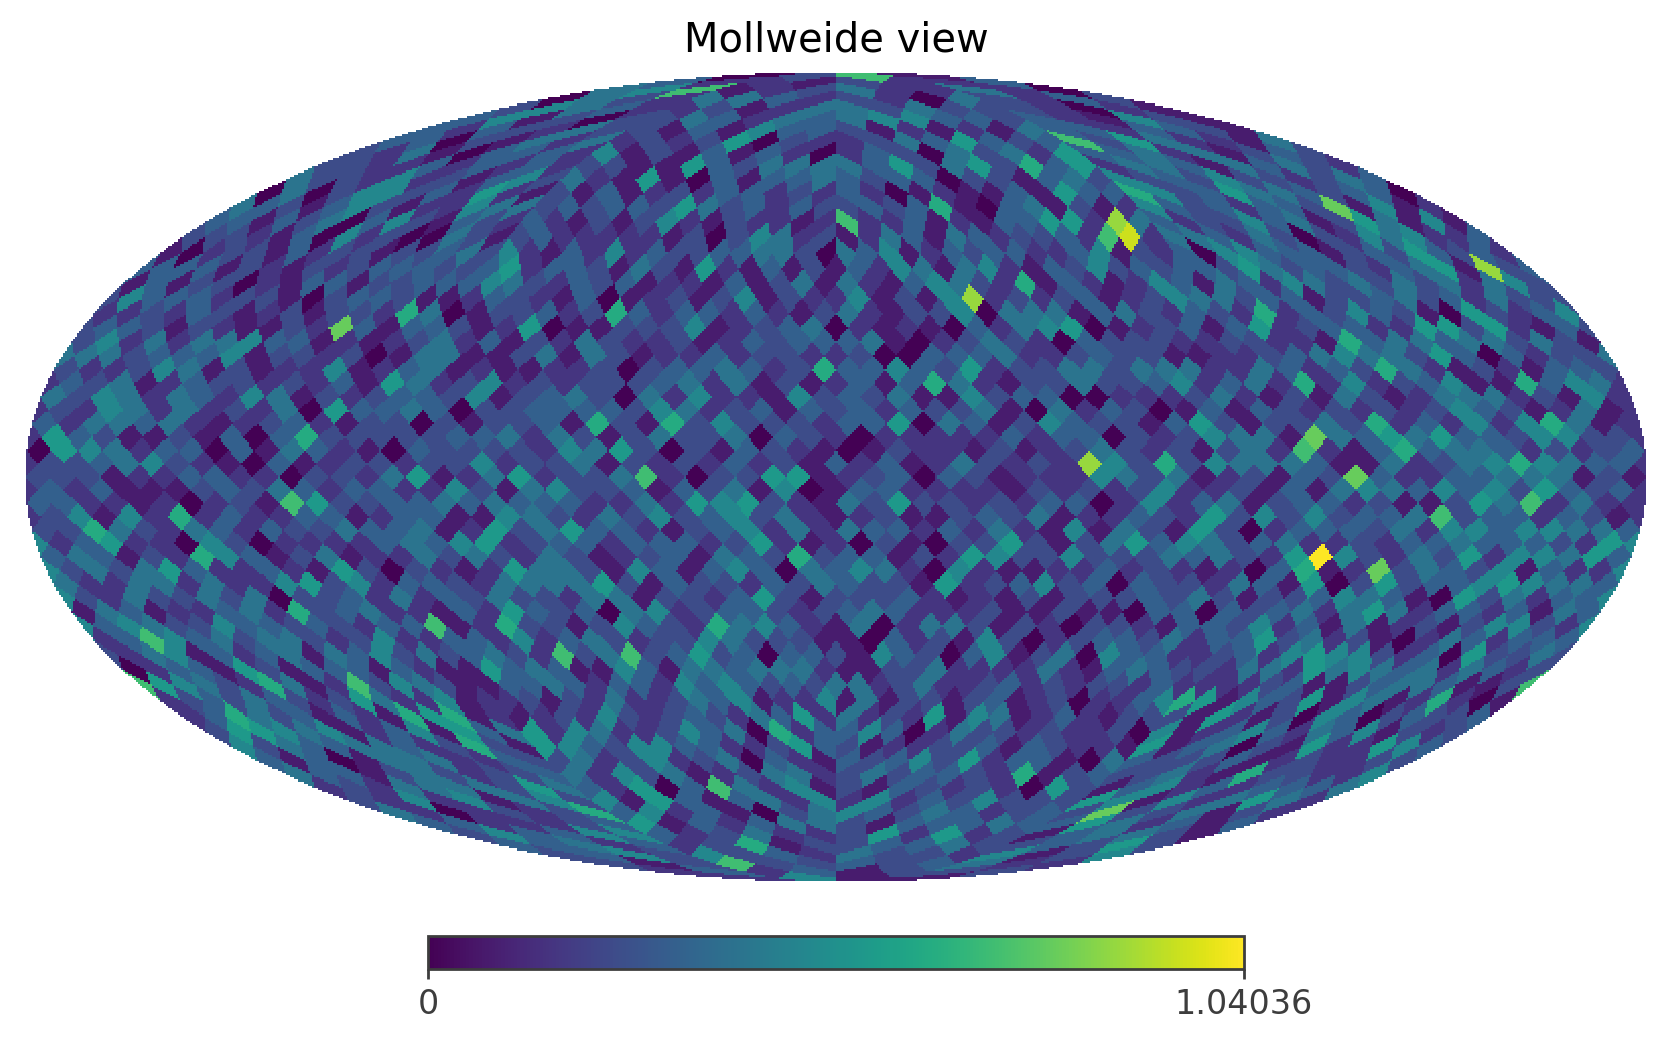

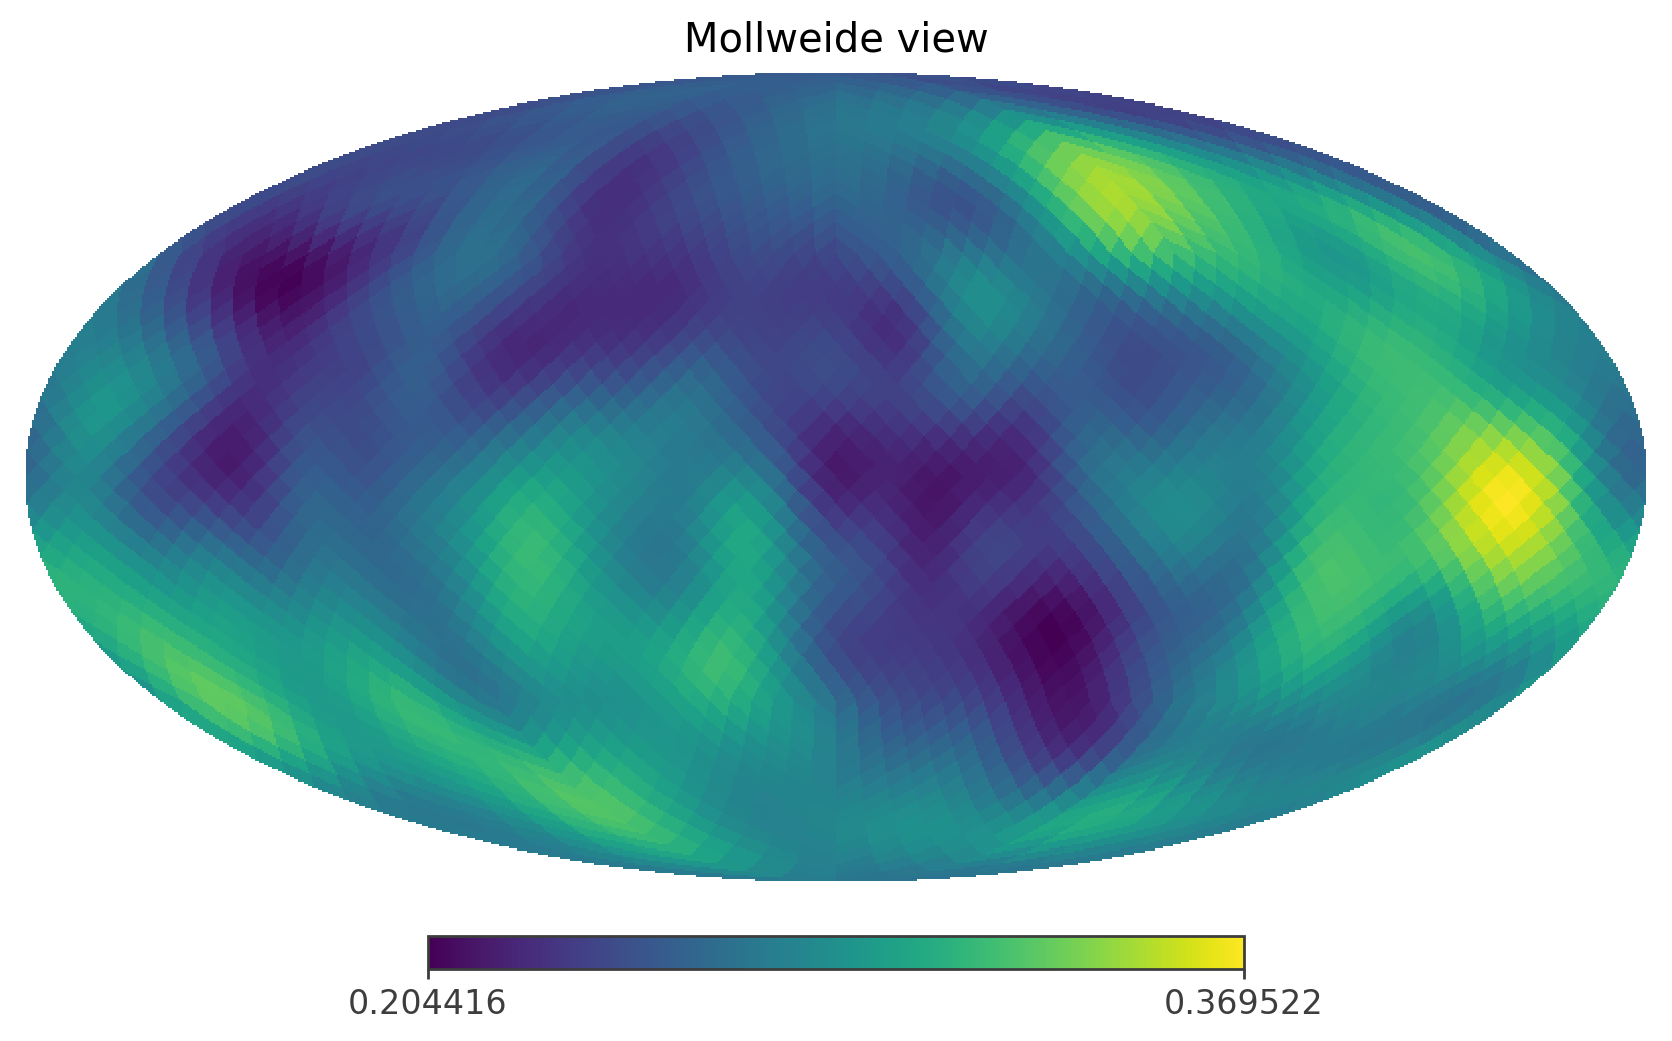

In [40]:
sliced_bkg_map = bkg_model_histogram[0,0,25]

hp.mollview(sliced_bkg_map)

sliced_smoothed_bkg_map = hp.smoothing(sliced_bkg_map, fwhm = (20.0 * u.deg).to('rad').value)

hp.mollview(sliced_smoothed_bkg_map)